# Pete Isles' Random Forest Nutrient Model
Reference: https://doi.org/10.1016/j.watres.2023.120876

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import data.utils as utils
import data.usgs_ob as usgs
import datetime as dt
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Functions

### `to_metricQ`

In [2]:
def to_metricQ(streamflow_dict, streamflow_colname='streamflow'):
	'''
	Converts an entire dictionary of streamflow Series (such as that returned by usgs_ob.get_data()) to 
	a dictionary of dataframes, where streamflow has been converted from cubic feet /s to cubic m / s.
	
	Args:
	-- streamflow_dict (dict) [req]: dictionary of streamflow series, in the nested format as returned by usgs_ob.get_data()
	-- streamflow_colname (str) [opt]: the name of the streamflow series (key used in variables param of usgs_ob.get_data())
	
	Returns:
	-- metric_q_fs (dict): dictionary with the same location-name keys as streamflow_dict, with values being DataFrames of converted streamflow
	'''
	metric_q_dfs = {}
	for location, q in streamflow_dict.items():
		# make a copy of the data and convert to cubic m / s
		metric_q = q[streamflow_colname].copy() * 0.0283168
		metric_q_dfs[location] = pd.DataFrame(metric_q)
	return metric_q_dfs

### `add_features()`

In [3]:
def add_features(df, streamflow_colname='streamflow'):
	'''
	Function to add features to a daily discharge dataframe for a USGS gauge. Features added are the same as those used by Isles, 2023 (https://doi.org/10.1016/j.watres.2023.120876)
	Exact specifications for how features were engineered can be found in the code contained in the supplmentary material of said paper.

	Args:
	-- df (pd.DataFrame) [req]: daily discharge dataframe for a given USGS gauge. Should have datetime index and single streamflow column
	-- streamflow_colname (str) [opt]: name of the streamflow column

	Returns:
	features_df: a new dataframe containing the features needed for RF training
	'''
	df_features = df.copy()
	# log10 of Q
	df_features['log10_q'] = np.log10(df_features[streamflow_colname])
	# Mean Q over days t-7 through t-1; calculated with logQ
	df_features['q_7d_rolling_ave'] = df_features['log10_q'].rolling(window=dt.timedelta(days=7), min_periods=7).mean().shift(1)
	# Mean Q over days t-30 through t-1; calculated with logQ
	df_features['q_30d_rolling_ave'] = df_features['log10_q'].rolling(window=dt.timedelta(days=30), min_periods=30).mean().shift(1)
	# ∆Q1day; calculated with Q
	df_features['q_1d_diff'] = df_features[streamflow_colname].diff()
	# day of year
	df_features['dofY'] = df_features.index.day_of_year
	# water year
	df_features['w_year'] = df_features.index.year
	df_features.index.name = 'date'
	df_features.index = df_features.index.tz_localize(None)
	return df_features.drop(columns=streamflow_colname)
	

### `preprocess_nutrients()`

In [4]:
def preprocess_nutrients(df):
	'''
	Preprocessing for nutrient data (TP and TN), gathered from thee Lake Champlain Tributary Long-term Monitoring Project
	https://dec.vermont.gov/watershed/lakes-ponds/monitor/lake-champlain-long-term-monitoring-project

	Args:
	-- df (pd.DataFrame) [req]: the raw nutrient dataframe, directly read in from csv

	Returns:
	df_processed (pd.DataFrame): a new dataframe containing a datetime index and a single column of nutrient data
	'''
	df_processed = df.copy()
	df_processed = df_processed.set_index(pd.to_datetime(df_processed['VisitDate']))
	df_processed.index.name = 'date'
	if df_processed['Test'].iloc[0] == 'Total Phosphorus':
		nutrient = 'TP_mg/L'
		# convert from ug/L to mg/L
		df_processed[nutrient] = df_processed['Result'] / 1000
	elif df_processed['Test'].iloc[0] == 'Total Nitrogen':
		nutrient = 'TN_mg/L'
		# TN already in mg/L
		df_processed[nutrient] = df_processed['Result']
	df_processed = df_processed.drop(columns=[c for c in df_processed.columns if c != nutrient])
	
	# some dataframes have duplicate dates (multiple samples on the same day)
	# to handle duplicates, let's calculate the mean for a duplicated day and use that value
	grouped = df_processed.groupby(df_processed.index).agg({nutrient: 'mean'})
	# Remove duplicate rows based on the index, keeping the first occurrence
	df_processed = df_processed[~df_processed.index.duplicated(keep='first')]
	# Update the column values with the calculated mean for duplicated timestamps
	df_processed.update(grouped)
	
	return df_processed

### `combine_data`

In [5]:
def combine_data(nutrient_dict, q_dict):
	'''
	Create a new dictionary of combined nutrient data and discharge features for a given location

	Args:
	-- nutrient_dict (dict) [req]: dictionary of nutrient data. Keys should be same location names as q_dict, values should be preprocessed nutrient data
	-- q_dict (dict) [req]: dictionary of discharge features dataframes, keyed by location.

	Returns:
	combined_dict (dict): a new dictionary of combined data, keys are the same as those of q_dict
	'''
	combined_dict = {}
	for loc, q_df in q_dict.items():
		nutrient_df = nutrient_dict[loc]
		combined_df = q_df.join(nutrient_df, how='inner', sort=True, validate='one_to_one')
		combined_dict[loc] = combined_df
	return combined_dict

### `train_rf`

In [66]:
def train_rf(data, nutrient_col, test_data_size=None, n_trees=500):
	'''
	Train a single random forest CQ model for a given tributary.

	Args:
	-- data (pd.DataFrame) [req]: The input data containing discharge feature columns and the target nutrient column.
	-- nutrient_col (str) [req]: The name of target nutrient column. Ex. 'TP_mg/L'
	-- test_data_size (float) [opt]: The proportion of the data to be used as the test set (between 0.0 and 1.0). Default is None (no split)
	-- n_trees (int) [opt]: The number of trees to be used in the Random Forest model. Default is 500 trees

	Returns:
	-- rf (RandomForestRegressor): The trained Random Forest model.
	-- x_test (pd.DataFrame): The test set features.
	-- y_test (pd.Series): The test set target values.
	'''
	# grab all features for X, nutrient column for Y
	x = data[[c for c in data.columns if c != nutrient_col]]
	y = data[nutrient_col]

	if test_data_size:
		# Split the data into training and testing sets
		x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_data_size, random_state=42)
	else:
		# if no train-test split, use all data
		x_train, y_train = x, y
		x_test, y_test = x, y

	# Create and train the Random Forest model
	rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
	rf.fit(x_train, y_train)

	return rf, x_test, y_test

### `build_nutrient_models`

In [117]:
def build_nutrient_models(model_data, nutrient, model_dir, test_data_size=None):
	'''
	Build and save a suite of random forest models for a given CQ relationship at multiple tributaries.

	Args:
	-- model_data (dict) [req]: A dictionary where keys are tributary names and values are dataframes containing complete model data (features and target) for that location.
	-- nutrient (str) [req]: The name of the nutrient column in the dataframes to be used as the target variable. Ex. 'TN_mg/L'
	-- model_dir (str) [req]: The directory where the trained models should be saved.
	-- test_data_size (float or None) [opt]: size of test data for split as a proportion between 0-1. Defaults to None (no train-test split).

	Returns:
	-- models (dict): A dictionary where keys are location names and values are dictionaries containing the trained model and the test data (`x_test`, `y_test`).
	'''
	models = {}
	for loc, data in model_data.items():
		# train model
		model, x_test, y_test = train_rf(data, nutrient, test_data_size)
		# saving the model with joblib package
		nutrient_name = nutrient.split('_')[0]
		model_path = os.path.join(model_dir, nutrient_name)
		model_fname = f'{loc}_{nutrient_name}.joblib'
		# make model save path if it doesn't exist
		if not os.path.exists(model_path):
			os.makedirs(model_path)
			print(f'Model path created: {model_path}')
		# save the model
		joblib.dump(model, os.path.join(model_path, model_fname))
		print(f'Model saved to: {os.path.join(model_path, model_fname)}')
		models[loc] = {'model':model, 'x_test':x_test, 'y_test':y_test}
	return models


### `feature_importances`

In [8]:
def feature_importances(model_dict):
	'''
	Calculate and print the feature importances for a given model.

	Args:
	-- model_dict (dict) [req]: A dictionary containing the trained model and test data, as returned by build_nutrient_models()[location]. Expected keys are:

	Returns:
	None
	'''
	# Calculate and print feature importances
	feature_importances = model_dict['model'].feature_importances_
	for feature, importance in zip(model_dict['x_test'].columns, feature_importances):
		print(f'Feature: {feature}, Importance: {importance}')

### `plot_scatter_with_metrics`

In [9]:
def plot_scatter_with_metrics(y_true, y_pred, nutrient, location, ax):
	# Calculate R-squared (R²) and Mean Squared Error (MSE)
	r2 = r2_score(y_true, y_pred)
	mse = mean_squared_error(y_true, y_pred)

	nutrient_name = nutrient.split('_')[0]
	unit = nutrient.split('_')[-1]
	
	# Create a scatter plot
	ax.scatter(y_true, y_pred, color='blue')

	# Add perfect predictions line
	ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='orange', linestyle='--', linewidth=2)

	# Add text for R-squared and MSE
	ax.text(0.30, 0.85, f'R² = {r2:.4f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='r')
	ax.text(0.30, 0.75, f'MSE = {mse:.4f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='r')

	# Add labels and title
	ax.set_xlabel(f'Actual {nutrient_name} ({unit})')
	ax.set_ylabel(f'Predicted {nutrient_name} ({unit})')
	ax.set_title(f'Random Forest {nutrient_name} Model for {location}')


### `make_figure`

In [10]:
def make_figure(tp_models, tn_models, n_row, n_col):
	# Create a grid of subplots
	fig, axs = plt.subplots(n_row, n_col, figsize=(14, 18))

	for i, (loc, model_dict) in enumerate(tp_models.items()):
		# Predict on the test set
		y_pred = model_dict['model'].predict(model_dict['x_test'])
		plot_scatter_with_metrics(model_dict['y_test'], y_pred, nutrient='TP_mg/L', location=loc, ax=axs[i,0])

	for i, (loc, model_dict) in enumerate(tn_models.items()):
		# Predict on the test set
		y_pred = model_dict['model'].predict(model_dict['x_test'])
		plot_scatter_with_metrics(model_dict['y_test'], y_pred, nutrient='TN_mg/L', location=loc, ax=axs[i,1])
	
	# Adjust the layout
	plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust these values as needed

	return fig

## Main Script

### Getting streamflow (Discharge aka Q)

In [11]:
# start and end date inferred from Peter's code
start_dt = dt.datetime(1990, 10, 1, tzinfo=dt.timezone.utc)
end_dt = dt.datetime(2023, 8, 31, tzinfo=dt.timezone.utc)

# USGS gauges we want discharge for
gauges = {'missisquoi':'04294000',
		  'mill':'04292750',
		  'jewett':'04292810',
		  'rock':'04294140',
		  'pike':'04294300'}
streamflow = {'discharge':'00060'}

In [12]:
# adding a day to end_dt because get_data()s are end date exclusive
daily_discharge = usgs.get_data(start_dt, end_dt+dt.timedelta(days=1), gauges, streamflow, service='dv')

In [13]:
daily_discharge

{'missisquoi': {'discharge': time
  1990-10-01 00:00:00+00:00    1520.0
  1990-10-02 00:00:00+00:00    1700.0
  1990-10-03 00:00:00+00:00    1800.0
  1990-10-04 00:00:00+00:00    1550.0
  1990-10-05 00:00:00+00:00    1900.0
                                ...  
  2023-08-27 00:00:00+00:00    1040.0
  2023-08-28 00:00:00+00:00     878.0
  2023-08-29 00:00:00+00:00     708.0
  2023-08-30 00:00:00+00:00    1000.0
  2023-08-31 00:00:00+00:00    2320.0
  Name: discharge, Length: 12023, dtype: float64},
 'mill': {'discharge': time
  2010-10-20 00:00:00+00:00    24.8
  2010-10-21 00:00:00+00:00    43.6
  2010-10-22 00:00:00+00:00    49.8
  2010-10-23 00:00:00+00:00    29.7
  2010-10-24 00:00:00+00:00    22.6
                               ... 
  2023-08-27 00:00:00+00:00    82.6
  2023-08-28 00:00:00+00:00    24.4
  2023-08-29 00:00:00+00:00    13.5
  2023-08-30 00:00:00+00:00    55.0
  2023-08-31 00:00:00+00:00    71.7
  Name: discharge, Length: 4699, dtype: float64},
 'jewett': {'discharge'

### Feature Engineering for Streamflow

In [14]:
# convert streamflow to metric
metric_q_dfs = to_metricQ(daily_discharge, streamflow_colname='discharge')

In [15]:
# add features to each df
features_dfs = {location:add_features(discharge_df, streamflow_colname='discharge').dropna() for location, discharge_df in metric_q_dfs.items()}

/users/n/b/nbeckage/miniconda3/envs/forecast/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/n/b/nbeckage/miniconda3/envs/forecast/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/n/b/nbeckage/miniconda3/envs/forecast/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
metric_q_dfs

{'missisquoi':                            discharge
 time                                
 1990-10-01 00:00:00+00:00  43.041536
 1990-10-02 00:00:00+00:00  48.138560
 1990-10-03 00:00:00+00:00  50.970240
 1990-10-04 00:00:00+00:00  43.891040
 1990-10-05 00:00:00+00:00  53.801920
 ...                              ...
 2023-08-27 00:00:00+00:00  29.449472
 2023-08-28 00:00:00+00:00  24.862150
 2023-08-29 00:00:00+00:00  20.048294
 2023-08-30 00:00:00+00:00  28.316800
 2023-08-31 00:00:00+00:00  65.694976
 
 [12023 rows x 1 columns],
 'mill':                            discharge
 time                                
 2010-10-20 00:00:00+00:00   0.702257
 2010-10-21 00:00:00+00:00   1.234612
 2010-10-22 00:00:00+00:00   1.410177
 2010-10-23 00:00:00+00:00   0.841009
 2010-10-24 00:00:00+00:00   0.639960
 ...                              ...
 2023-08-27 00:00:00+00:00   2.338968
 2023-08-28 00:00:00+00:00   0.690930
 2023-08-29 00:00:00+00:00   0.382277
 2023-08-30 00:00:00+00:00   1.557424

In [17]:
features_dfs['missisquoi'].index

DatetimeIndex(['1990-10-31', '1990-11-01', '1990-11-02', '1990-11-03',
               '1990-11-04', '1990-11-05', '1990-11-06', '1990-11-07',
               '1990-11-08', '1990-11-09',
               ...
               '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
               '2023-08-26', '2023-08-27', '2023-08-28', '2023-08-29',
               '2023-08-30', '2023-08-31'],
              dtype='datetime64[ns]', name='date', length=11993, freq=None)

### Aquiring Nutirent Data
##### Nutrient Data is gathered from [Lake Champlain Tributary Long-term Monitoring Project](https://dec.vermont.gov/watershed/lakes-ponds/monitor/lake-champlain-long-term-monitoring-project)
##### We are using total phosphorus (TP, ug/L) and total nitrogen (TN, mg/L) for each of the following 5 Monitoring sites:
- Missisquoi River
- Mill River
- Jewett Brook
- Rock River
- Pike River

In [18]:
tp_dir = "/users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/nutrient_data/TP"
tn_dir = "/users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/nutrient_data/TN"

In [19]:
tp = {file.split('_')[0]:pd.read_csv(os.path.join(tp_dir, file)) for file in os.listdir(tp_dir)}
tn = {file.split('_')[0]:pd.read_csv(os.path.join(tn_dir, file)) for file in os.listdir(tn_dir)}

In [20]:
tp_processed = {location:preprocess_nutrients(tp_df) for location, tp_df in tp.items()}
tn_processed = {location:preprocess_nutrients(tn_df) for location, tn_df in tn.items()}

In [21]:
full_tp = combine_data(tp_processed, features_dfs)
full_tn = combine_data(tn_processed, features_dfs)

### Training Random Forest Model

In [118]:
# build and save models for nitrogren and phosphorus
tp_models = build_nutrient_models(full_tp, 'TP_mg/L', model_dir='/users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/')
tn_models = build_nutrient_models(full_tn, 'TN_mg/L', model_dir='/users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/')

Model path created: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TP
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TP/missisquoi_TP.joblib
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TP/mill_TP.joblib
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TP/jewett_TP.joblib
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TP/rock_TP.joblib
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TP/pike_TP.joblib
Model path created: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TN
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TN/missisquoi_TN.joblib
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models/TN/mill_TN.joblib
Model saved to: /users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/mod

In [70]:
full_tp['missisquoi']

,log10_q,q_7d_rolling_ave,q_30d_rolling_ave,q_1d_diff,dofY,w_year,TP_mg/L
date,,,,,,,
1990-11-07,1.794467,1.394510,1.732340,31.148480,311,1990,0.0350
1990-11-12,1.813772,1.636989,1.739173,-16.990080,316,1990,0.0640
1990-11-27,1.628135,1.725098,1.701174,-5.663360,331,1990,0.0270
1991-02-08,1.853445,1.420889,1.373877,16.990080,39,1991,0.0520
1991-02-20,1.541949,1.288170,1.378842,17.471466,51,1991,0.0280
...,...,...,...,...,...,...,...
2023-05-05,1.778380,1.870982,2.075757,-14.724736,125,2023,0.0203
2023-07-11,2.742079,1.586352,1.467523,445.423264,192,2023,0.5720
2023-07-17,2.252761,2.285978,1.701190,95.427616,198,2023,0.0680


In [69]:
tp_models['missisquoi']['x_test']

,log10_q,q_7d_rolling_ave,q_30d_rolling_ave,q_1d_diff,dofY,w_year
date,,,,,,
1990-11-07,1.794467,1.394510,1.732340,31.148480,311,1990
1990-11-12,1.813772,1.636989,1.739173,-16.990080,316,1990
1990-11-27,1.628135,1.725098,1.701174,-5.663360,331,1990
1991-02-08,1.853445,1.420889,1.373877,16.990080,39,1991
1991-02-20,1.541949,1.288170,1.378842,17.471466,51,1991
...,...,...,...,...,...,...
2023-05-05,1.778380,1.870982,2.075757,-14.724736,125,2023
2023-07-11,2.742079,1.586352,1.467523,445.423264,192,2023
2023-07-17,2.252761,2.285978,1.701190,95.427616,198,2023


### Visualizing Results

<Figure size 640x480 with 0 Axes>

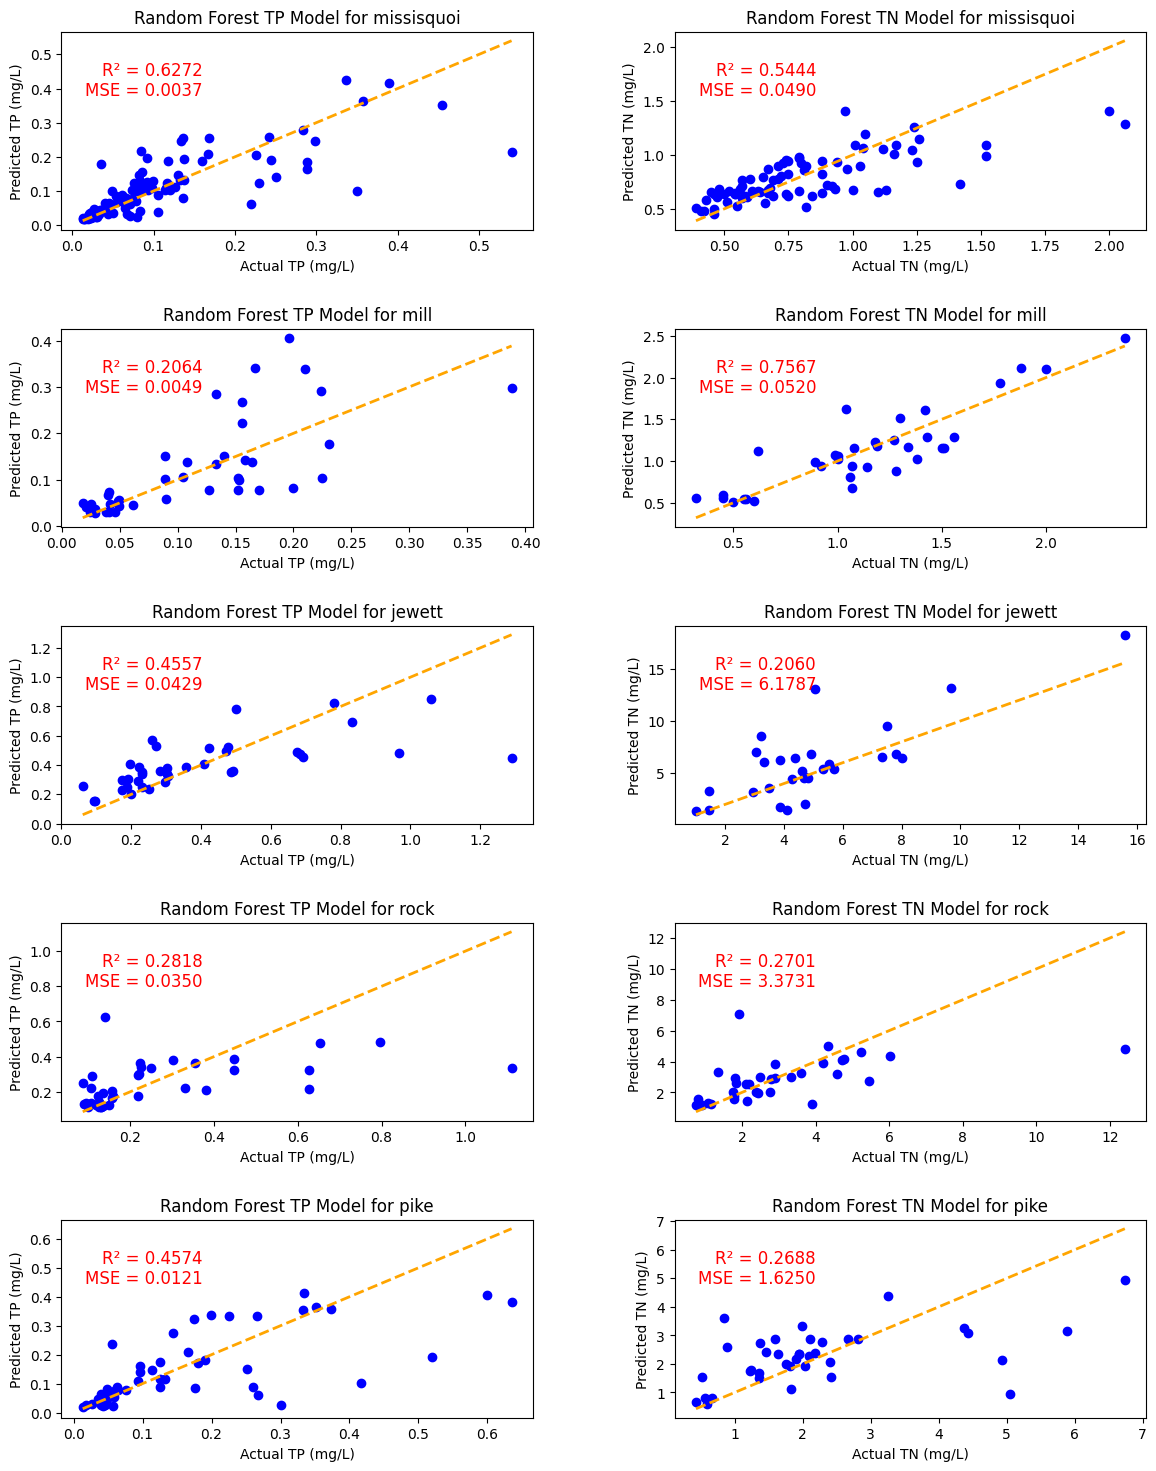

In [46]:
# create and save figure
plt.clf()
fig = make_figure(tp_models, tn_models, n_row=5, n_col=2)
fig.savefig('/users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/scatter_plots_with_metrics.png')
plt.show()

## `waterquality.py` integration

### Sample Streamflow Data

#### Args

In [24]:
start = dt.datetime(2023, 1, 1)
end = dt.datetime(2023, 6, 8)
rock = {'rock':'04294140'}

#### Getting Streamflow

In [25]:
rock_q = usgs.get_data(start, end, rock)
rock_q

{'rock': {'streamflow': time
  2023-01-01 01:00:00+00:00    71.80
  2023-01-01 01:15:00+00:00    71.80
  2023-01-01 01:30:00+00:00    71.80
  2023-01-01 01:45:00+00:00    72.70
  2023-01-01 02:00:00+00:00    72.70
                               ...  
  2023-06-07 22:45:00+00:00     0.23
  2023-06-07 23:00:00+00:00     0.23
  2023-06-07 23:15:00+00:00     0.23
  2023-06-07 23:30:00+00:00     0.23
  2023-06-07 23:45:00+00:00     0.23
  Name: streamflow, Length: 4812, dtype: float64}}

In [96]:
df = pd.DataFrame(rock_q['rock']['streamflow'])

In [97]:
rock_q['rock']['streamflow']

time
2023-01-01 01:00:00+00:00    71.80
2023-01-01 01:15:00+00:00    71.80
2023-01-01 01:30:00+00:00    71.80
2023-01-01 01:45:00+00:00    72.70
2023-01-01 02:00:00+00:00    72.70
                             ...  
2023-06-07 22:45:00+00:00     0.23
2023-06-07 23:00:00+00:00     0.23
2023-06-07 23:15:00+00:00     0.23
2023-06-07 23:30:00+00:00     0.23
2023-06-07 23:45:00+00:00     0.23
Name: streamflow, Length: 4812, dtype: float64

### Load Models

In [26]:
model_dir  = "/users/n/b/nbeckage/ciroh/workspaces/notebooks/FEE/randForest/models"

In [27]:
rf_models = {}
for basedir, subdirs, files in os.walk(model_dir):
	# print(f'basedir: {basedir}')
	# print(f'subdirs: {subdirs}')
	# print(f'files: {files}')
	if files:
		rf_models[files[0].split('.')[0]] =  joblib.load(os.path.join(basedir, files[0]))

In [71]:
rock_tp = rf_models['rock_TP']

In [72]:
rock_tp

RandomForestRegressor(n_estimators=500, random_state=42)

### Prepare Streamflow for Model Predictions

In [82]:
# we don't need to do metric conversions when we integrate into waterquality.py
rock_q_features = add_features(to_metricQ(rock_q)['rock']).dropna()
rock_q_features

,log10_q,q_7d_rolling_ave,q_30d_rolling_ave,q_1d_diff,dofY,w_year
date,,,,,,
2023-01-01 08:30:00,0.501262,0.368870,0.368870,0.056634,1,2023
2023-01-01 08:45:00,0.512742,0.373141,0.373141,0.084950,1,2023
2023-01-01 09:00:00,0.520230,0.377503,0.377503,0.056634,1,2023
2023-01-01 09:15:00,0.523926,0.381828,0.381828,0.028317,1,2023
2023-01-01 09:30:00,0.527591,0.386008,0.386008,0.028317,1,2023
...,...,...,...,...,...,...
2023-06-07 22:45:00,-2.186228,-2.205661,-1.942378,0.000000,158,2023
2023-06-07 23:00:00,-2.186228,-2.205764,-1.942599,0.000000,158,2023
2023-06-07 23:15:00,-2.186228,-2.205936,-1.942818,0.000000,158,2023


In [83]:
# rock_q_features = add_features(pd.DataFrame(rock_q['rock']['streamflow'])).dropna()
# rock_q_features

### Make Model Predictions

In [84]:
rock_tp_pred = rock_tp.predict(rock_q_features)

In [85]:
rock_q_features['TP'] = rock_tp_pred

In [86]:
rock_q_features

,log10_q,q_7d_rolling_ave,q_30d_rolling_ave,q_1d_diff,dofY,w_year,TP
date,,,,,,,
2023-01-01 08:30:00,0.501262,0.368870,0.368870,0.056634,1,2023,0.254820
2023-01-01 08:45:00,0.512742,0.373141,0.373141,0.084950,1,2023,0.256200
2023-01-01 09:00:00,0.520230,0.377503,0.377503,0.056634,1,2023,0.256990
2023-01-01 09:15:00,0.523926,0.381828,0.381828,0.028317,1,2023,0.255296
2023-01-01 09:30:00,0.527591,0.386008,0.386008,0.028317,1,2023,0.255296
...,...,...,...,...,...,...,...
2023-06-07 22:45:00,-2.186228,-2.205661,-1.942378,0.000000,158,2023,0.124748
2023-06-07 23:00:00,-2.186228,-2.205764,-1.942599,0.000000,158,2023,0.124748
2023-06-07 23:15:00,-2.186228,-2.205936,-1.942818,0.000000,158,2023,0.124748
